In [ ]:
%%writefile sentiment_models.py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential  # We use Keras API for training model
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Definition of Core Functions
def load_and_preprocess(filepath):
    """
    The data is loaded and subjected to basic preprocessing, mapping, and visualization; subsequently,
    the text is converted into sequences and split into training and testing sets
    Return: X_train, X_test, y_train, y_test, y_train_oh, y_test_oh, vocab_size, maxlen
    """
    # 1. Load the data
    df = pd.read_csv(
        filepath,
        sep='\t',
        header=None,
        names=['ID', 'TOPIC', 'SENTIMENT', 'TWEET'],
        quoting=3,
        engine='python'
    )

    # 2. Display the original sentiment distribution
    print("===== Original Sentiment Distribution (Before Remapping) =====")
    print(df['SENTIMENT'].value_counts())  # Count the occurrences of each sentiment label

    # 3. Plot the original sentiment distribution
    # Plot a bar chart to visualize the frequency of each label
    plt.figure(figsize=(6,4))
    sns.countplot(x='SENTIMENT', data=df, order=sorted(df['SENTIMENT'].unique()))
    plt.title("Original Sentiment Distribution")
    plt.show()

    # 4. Display a sample of the dataset (first five rows)
    #print("\n===== Sample of the data (first 5 rows) =====")
    #print(df.head())

    # 5. Map the sentiment labels to the range [0–4]
    #    -2 -> 0, -1 -> 1,  0 -> 2,  1 -> 3,  2 -> 4
    label_map = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    df['SENTIMENT'] = df['SENTIMENT'].map(label_map)

    # 6. Prepare for tokenization and sequence conversion
    # Convert the text in the TWEET column to string format, then tokenize and transform it into integer sequences using a tokenizer
    tweets = df['TWEET'].astype(str)
    labels = df['SENTIMENT'].values

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets)
    sequences = tokenizer.texts_to_sequences(tweets)
    maxlen = max(len(seq) for seq in sequences)  # Retrieve the longest sequence among all tweets

    # Apply post-padding to ensure all input sequences have the same length
    padded_seq = pad_sequences(sequences, maxlen=maxlen, padding='post')
    vocab_size = len(tokenizer.word_index) + 1

    # 7. Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        padded_seq,
        labels,
        test_size=0.2, # 20% for testing
        random_state=42
    )
    y_train_oh = to_categorical(y_train, num_classes=5)
    y_test_oh = to_categorical(y_test, num_classes=5)

    return X_train, X_test, y_train, y_test, y_train_oh, y_test_oh, vocab_size, maxlen


# ========== Build a basic RNN model ==========
def train_simple_rnn(X_train, y_train_oh, vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 50, input_length=maxlen), # Word embedding layer (output size: 50)
        SimpleRNN(50, activation='tanh'), # Activation function: tanh
        Dense(5, activation='softmax') # Output probability distribution over 5 classes
    ])
    # Training for 5 epochs with a batch size of 64 and a validation split of 20%
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_oh, epochs=5, batch_size=64, validation_split=0.2)
    return model


# ========== Bidirectional LSTM Model ==========
def train_bilstm(X_train, y_train_oh, vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 32, input_length=maxlen), # Embedding dimension: 32
        Bidirectional(LSTM(64, return_sequences=True)), # Number of hidden units: 64
        Bidirectional(LSTM(64)),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_oh, epochs=5, batch_size=64, validation_split=0.2)
    return model


# ========== Simple 1D Convolutional Neural Network ==========
def train_cnn(X_train, y_train_oh, vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 50, input_length=maxlen),
        Conv1D(64, 3, activation='relu'), # Convolutional layer with 64 filters and a kernel size of 3
        GlobalMaxPooling1D(),        # Apply max pooling over the time dimension
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_oh, epochs=5, batch_size=64, validation_split=0.2) # Batch size: 64
    return model


def evaluate_model(model, X_test, y_test):
    # Make predictions and generate the classification report
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues') # Perform Visualization
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Overwriting sentiment_models.py


===== Example of the data after custom cleaning and augmentation =====
                   id        topic  label_num  \
0  681563394940473347  amy schumer         -1   
1  675847244747177984  amy schumer         -1   
2  672827854279843840  amy schumer         -1   
3  671502639671042048  amy schumer         -1   
4  677359143108214784  amy schumer         -1   

                                           tweet_raw           label  \
0  @MargaretsBelly Amy Schumer is the stereotypic...  WEAKLYNEGATIVE   
1  @dani_pitter I mean I get the hype around JLaw...  WEAKLYNEGATIVE   
2  Amy Schumer at the #GQmenoftheyear2015 party i...  WEAKLYNEGATIVE   
3  Amy Schumer may have brought us Trainwreck, bu...  WEAKLYNEGATIVE   
4  I just think that sports are stupid &amp;anyon...  WEAKLYNEGATIVE   

                                               tweet  \
0  Amy Schumer is the stereotypical 1st world Lac...   
1  I mean I get the hype around JLaw I may not li...   
2  Amy Schumer at the GQmenofthey

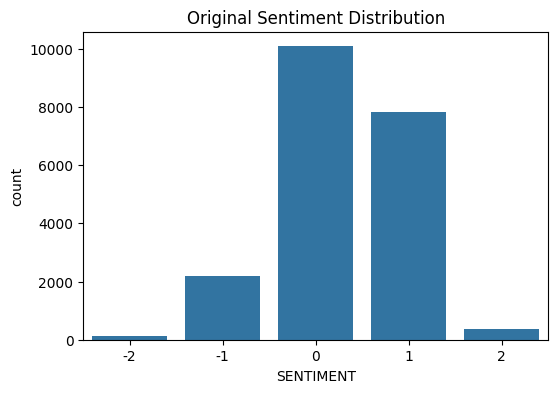

In [ ]:
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import previously defined functions from sentiment_models
from sentiment_models import (
    load_and_preprocess,
    train_simple_rnn,
    train_bilstm,
    train_cnn,
    evaluate_model
)

# ============== 1. Data loading and cleaning ==============
# The same file is read in, followed by customized cleaning, scoring, and splitting operations
data_path = "/content/SemEval2017-task4-dev.subtask-CE.english.INPUT.txt"

df = pd.read_csv(
    data_path,
    sep='\t',
    header=None,
    names=['id', 'topic', 'label_num', 'tweet_raw'],
)

# Mapping between numerical and string sentiment labels
label_map = {
    -2: "STRONGLYNEGATIVE",
    -1: "WEAKLYNEGATIVE",
     0: "NEUTRAL",
     1: "WEAKLYPOSITIVE",
     2: "STRONGLYPOSITIVE"
}
df['label'] = df['label_num'].map(label_map)  # Convert numeric labels to human-readable strings

def basic_text_cleaning(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)  # "Remove user mentions @someone
    text = re.sub(r"#", "", text)     # Remove topic markers #
    text = re.sub(r"[^A-Za-z0-9(),!?\'`]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['tweet'] = df['tweet_raw'].astype(str).apply(basic_text_cleaning)

# For compatibility with BERT's input format, each tweet is combined with its corresponding topic into a single string
df['input_text'] = df.apply(
    lambda row: f"[TOPIC] {row['topic']} [SEP] {row['tweet']}",
    axis=1
)

# ============== 2. Sentiment lexicon augmentation ==============
# We use a simple sentiment lexicon for scoring here
senti_lexicon = {
    "love": 2, "like": 1, "good": 1,
    "hate": -2, "bad": -1, "horrible": -2
}
def lexicon_score(sentence):
    words = sentence.lower().split()
    score = 0
    for w in words:
        if w in senti_lexicon:
            score += senti_lexicon[w]
    return score

df['lexicon_score'] = df['tweet'].apply(lexicon_score) # Store the score in df['lexicon_score']

# ============== 3. Data splitting and handling of class imbalance ==============
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])  # 转成0~4

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label_id']
)

# Compute class weights for use in weighted cross-entropy loss
train_labels_array = train_df['label_id'].to_numpy()
class_counts = Counter(train_labels_array)  # Count the occurrences of each class in the training set
num_samples = len(train_labels_array)
num_classes = len(class_counts)
weights = [
    num_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
]
class_weights = torch.tensor(weights, dtype=torch.float)

print("===== Example of the data after custom cleaning and augmentation =====")
print(df.head())

# Directly use the previously defined function: load_and_preprocess
# Read the file from the same data_path and apply its internal preprocessing logic
print("\n\n===== Utilizing the original load_and_preprocess(...) function for training =====")
X_train, X_test, y_train, y_test, y_train_oh, y_test_oh, vocab_size, maxlen = load_and_preprocess(data_path)


==== Simple RNN ====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4707 - loss: 1.1110 - val_accuracy: 0.3862 - val_loss: 1.0792
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4651 - loss: 1.1456 - val_accuracy: 0.4808 - val_loss: 1.0801
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4953 - loss: 1.0658 - val_accuracy: 0.4820 - val_loss: 1.0839
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5938 - loss: 0.9704 - val_accuracy: 0.4605 - val_loss: 1.1350
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8001 - loss: 0.5994 - val_accuracy: 0.3959 - val_loss: 1.5213
Evaluating Simple RNN...
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.09      0.12      0.11       395
           2       0.52      0.42      0.47      2024
           3       0.41      0.51      0.45      1589
           4       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


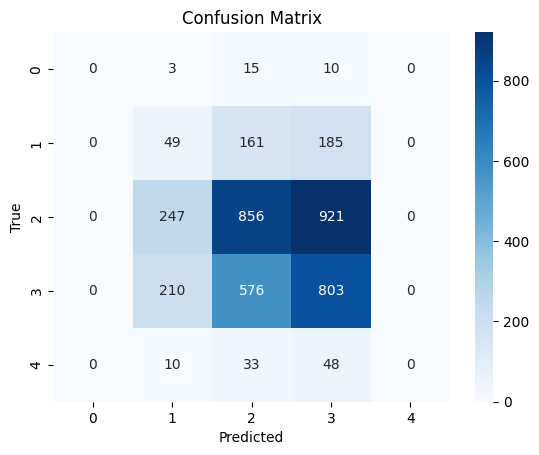

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



==== BiLSTM ====
Epoch 1/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4904 - loss: 1.1184 - val_accuracy: 0.5965 - val_loss: 0.9180
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6801 - loss: 0.7724 - val_accuracy: 0.6174 - val_loss: 0.8833
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8188 - loss: 0.4942 - val_accuracy: 0.6035 - val_loss: 1.0194
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9084 - loss: 0.2767 - val_accuracy: 0.5889 - val_loss: 1.2149
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9434 - loss: 0.1759 - val_accuracy: 0.5859 - val_loss: 1.5270
Evaluating BiLSTM...
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.17      0.04      0.06        28
           1       0.40      0.32      0.36       395
           2       0.62      0.73      0.67      2024
           3       0.63      0.55      0.59      1589
        

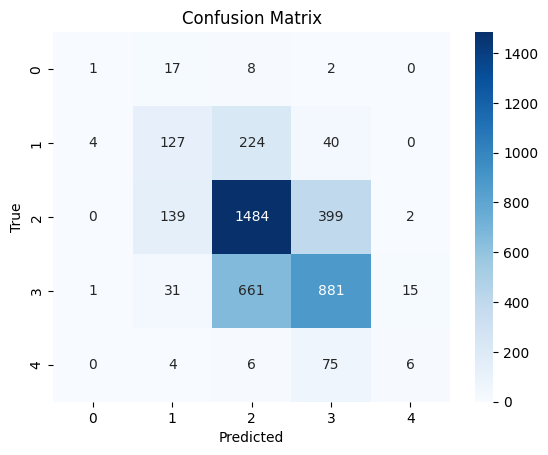


==== CNN ====
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4740 - loss: 1.2277 - val_accuracy: 0.5707 - val_loss: 0.9715
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6375 - loss: 0.8743 - val_accuracy: 0.6186 - val_loss: 0.8906
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7995 - loss: 0.5908 - val_accuracy: 0.6180 - val_loss: 0.9225
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8969 - loss: 0.3414 - val_accuracy: 0.5953 - val_loss: 0.9979
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9403 - loss: 0.2096 - val_accuracy: 0.5838 - val_loss: 1.1188
Evaluating CNN...
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.37      0.25      0.30       395
           2       0.62      0.70      0.66      2024
           3       0.60      0.59      0.59      1589
           4       0.12      0.02      0.04 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


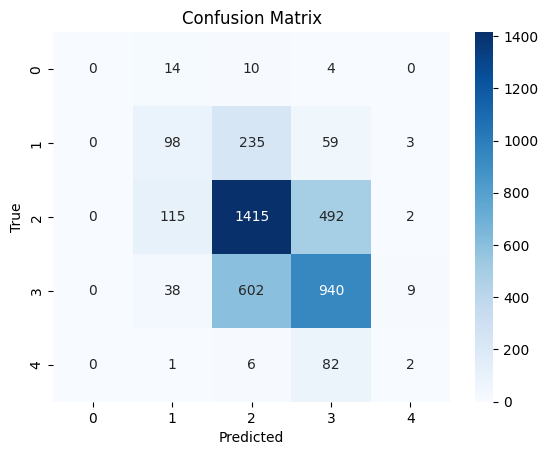

In [ ]:
# ================================
#        1) Simple RNN
# ================================
print("\n==== Simple RNN ====")
model_rnn = train_simple_rnn(X_train, y_train_oh, vocab_size, maxlen)
print("Evaluating Simple RNN...")
evaluate_model(model_rnn, X_test, y_test)

# ================================
#        2) BiLSTM
# ================================
print("\n==== BiLSTM ====")
model_bilstm = train_bilstm(X_train, y_train_oh, vocab_size, maxlen)
print("Evaluating BiLSTM...")
evaluate_model(model_bilstm, X_test, y_test)

# ================================
#        3) CNN
# ================================
print("\n==== CNN ====")
model_cnn = train_cnn(X_train, y_train_oh, vocab_size, maxlen)
print("Evaluating CNN...")
evaluate_model(model_cnn, X_test, y_test)